In [1]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
from IPython.display import HTML, clear_output


import brax
import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac
import matplotlib.pyplot as plt
import plotly.express as px
import time
from datetime import datetime

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


# Initial Rollout

In [2]:
# from bracketbot_env import BracketBot

In [3]:
# envs.register_environment("BracketBot", BracketBot)
# env = envs.get_environment("BracketBot")

# jit_reset = jax.jit(env.reset)
# jit_step = jax.jit(env.step)

In [4]:
from bracketbot_env_balance import Balance_BracketBot

In [5]:
envs.register_environment("Balance_BracketBot", Balance_BracketBot)
env = envs.get_environment("Balance_BracketBot")

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

/Users/magi/Code/robots/.venv/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [6]:
ROLLOUT_LENGTH = 1000

In [52]:
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)

# make it roll
rollout = [state.pipeline_state]
metrics_keys = state.metrics.keys()
metrics = {key : [] for key in metrics_keys}



for i in range(ROLLOUT_LENGTH):
    rng, _ = jax.random.split(rng)
    action = jax.random.uniform(rng, (env.action_size,), minval=-1, maxval=1)
    done = state.done
    state = jit_step(state, action)

    if not done:
        state = jit_step(state, action)
    else:
        state = jit_reset(rng)

    rollout.append(state.pipeline_state)
    for key in metrics_keys:
        metrics[key].append(state.metrics[key])

    
# html_content = html.render(env.sys, rollout)
# with open('untrained_rollout.html', 'w') as out:
#     out.write(html_content)  
HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

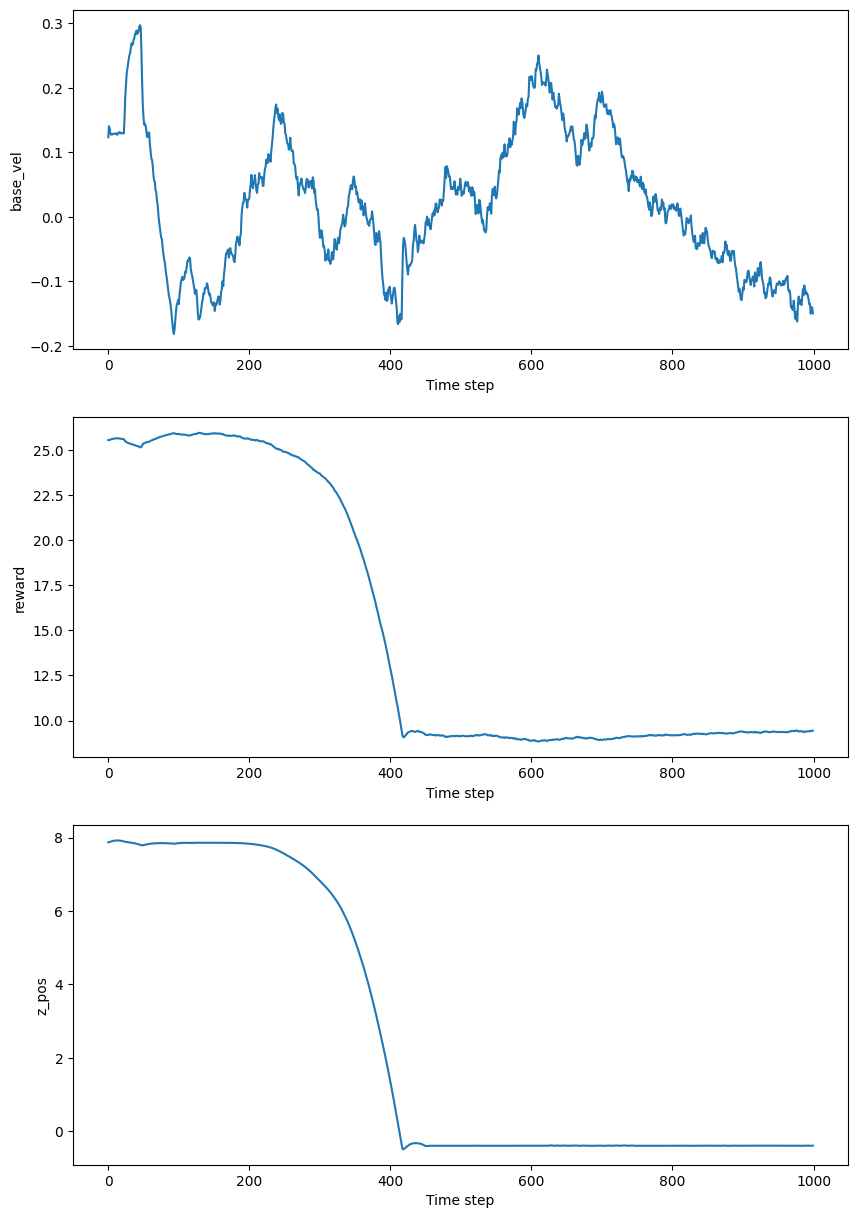

In [69]:
n = len(metrics_keys)
plt.figure(figsize=(10, 5 * n))

i = 1
for k, v in metrics.items():
    plt.subplot(n, 1, i)
    plt.xlabel("Time step")
    plt.ylabel(f"{k}")
    plt.plot(v)
    i += 1



In [39]:
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)

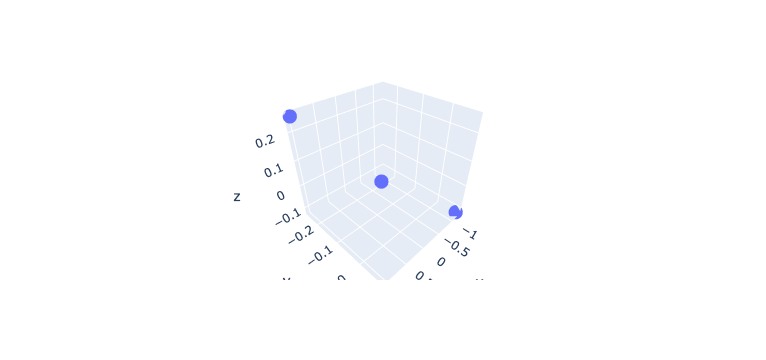

In [40]:
action = jax.random.uniform(rng, (env.action_size,), minval=-2, maxval=2)
state = jit_step(state, action)

pipeline_state = state.pipeline_state
xs = pipeline_state.x.pos[:, 0]
ys = pipeline_state.x.pos[:, 1]
zs = pipeline_state.x.pos[:, 2]

fig = px.scatter_3d(x=xs, y=ys, z=zs)
fig.show()

In [41]:
train_fn = functools.partial(
    ppo.train,
    num_timesteps=20_000_000, 
    num_evals=20,
    reward_scaling=10, # changed to 10
    episode_length=000, 
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10, #original was 5
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=4096, # the number of parallel environments running 
    batch_size=2048,
    seed=0
)

In [10]:
# code was borrowed from Brax's `tutorial` collab notebook

# going to add how long the average rollout last...
xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics['eval/episode_reward'])
    clear_output(wait=True)
    plt.xlim([0, train_fn.keywords['num_timesteps']])
    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.plot(xdata, ydata)
    plt.show()


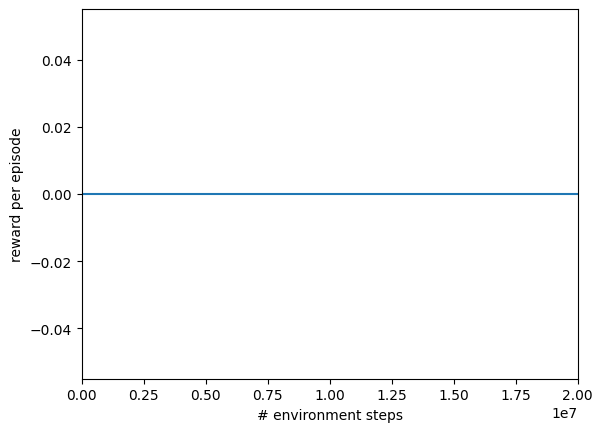

In [11]:
time_start = time.time()
make_inference_fn, params, metrics = train_fn(
    environment=env,
    progress_fn=progress)
time_end = time.time()

In [12]:
print(f"Time to Train: {(time_end - time_start) / 60:2f} mins.")

Time to Train: 50.795384 mins.


In [13]:
model.save_params("bracket_policy_v3", params)
params = model.load_params("bracket_policy_v3")
inference_fn = make_inference_fn(params) 

In [14]:
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout_pole_z = [state.metrics['pole_angle']]
rollout_vel = [state.metrics['forward_vel']]
rollout = [state.pipeline_state]

for i in range(ROLLOUT_LENGTH):
    rng, _ = jax.random.split(rng)
    action = jax.random.uniform(rng, (env.action_size,), minval=-1, maxval=3)
    done = state.done
    state = jit_step(state, action)

    if not done:
        state = jit_step(state, action)
    else:
        state = jit_reset(rng)

    rollout_pole_z.append(state.metrics['pole_angle'])
    rollout_vel.append(state.metrics['forward_vel'])
    rollout.append(state.pipeline_state)
    

html_content = html.render(env.sys, rollout)
with open('trained_rollout_v3.html', 'w') as out:
    out.write(html_content)  
# HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

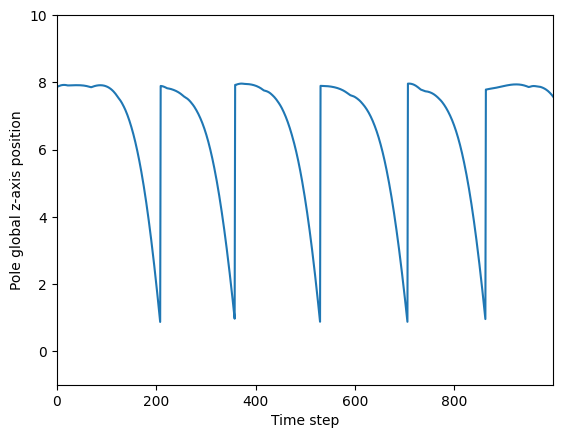

In [16]:
plt.xlabel("Time step")
plt.ylabel("Pole global z-axis position")
plt.ylim([-1, 10])
plt.xlim([0, ROLLOUT_LENGTH - 1])
 
plt.plot(rollout_pole_z)
plt.show()

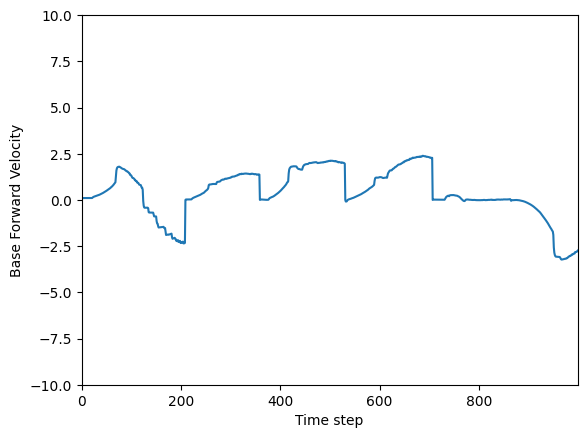

In [17]:
plt.xlabel("Time step")
plt.ylabel("Base Forward Velocity")
plt.ylim([-10, 10])
plt.xlim([0, ROLLOUT_LENGTH - 1])
 
plt.plot(rollout_vel)
plt.show()

In [ ]:
print(env.action_size)
print(env.observation_size)